In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [21]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train[y_train == 7]
y_train = y_train[y_train == 7]

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

hidden_dim = 2

(6000, 28, 28) (6000,)


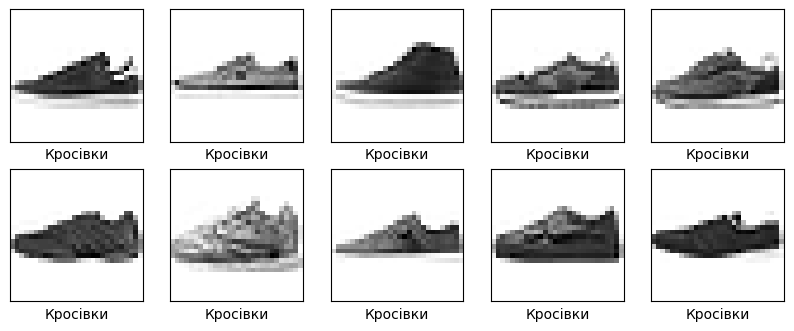

In [22]:
class_names = ['Футболка', 'Штани', 'Світшот', 'Сукня', 'Пальто', 
               'Сандалі', 'Сорочка', 'Кросівки', 'Сумка', 'Чоботи']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [13]:
def dropout_and_batch():
  return Dropout(0.3)(BatchNormalization())

generator = tf.keras.Sequential([
  Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
  BatchNormalization(),
  Reshape((7, 7, 256)),
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])

discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

1/20: ==========: tf.Tensor(1.3090168, shape=(), dtype=float32)
the time of epoch 1 is 13.78008246421814 seconds
2/20: ==========: tf.Tensor(1.7718742, shape=(), dtype=float32)
the time of epoch 2 is 12.374870777130127 seconds
3/20: ==========: tf.Tensor(2.0011077, shape=(), dtype=float32)
the time of epoch 3 is 12.90409779548645 seconds
4/20: ==========: tf.Tensor(1.9376944, shape=(), dtype=float32)
the time of epoch 4 is 13.426397800445557 seconds
5/20: ==========: tf.Tensor(1.7698171, shape=(), dtype=float32)
the time of epoch 5 is 13.23346209526062 seconds
6/20: ==========: tf.Tensor(1.3525044, shape=(), dtype=float32)
the time of epoch 6 is 12.986778736114502 seconds
7/20: ==========: tf.Tensor(1.0567895, shape=(), dtype=float32)
the time of epoch 7 is 14.254186630249023 seconds
8/20: ==========: tf.Tensor(0.9940996, shape=(), dtype=float32)
the time of epoch 8 is 13.99797511100769 seconds
9/20: ==========: tf.Tensor(1.0135891, shape=(), dtype=float32)
the time of epoch 9 is 14.57

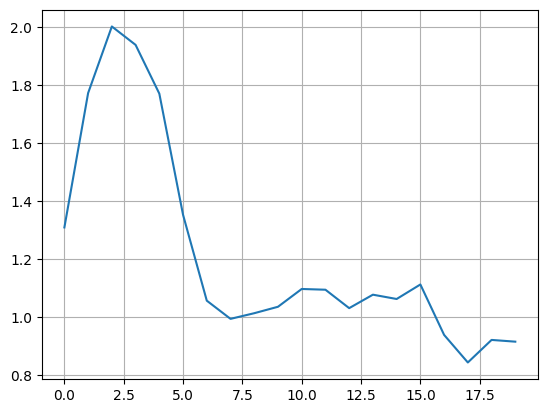

1/1 [==============================] - 0s 16ms/step


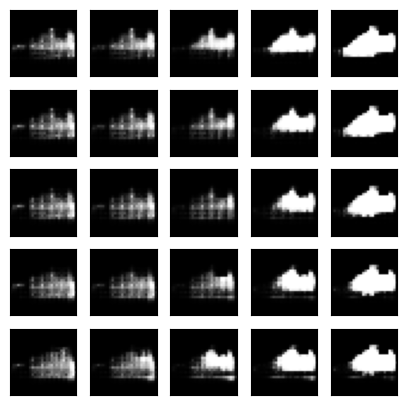

In [15]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss


def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

  for epoch in range(1, epochs + 1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if (n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch / n]
    print(': ' + str(history[-1]))
    print('the time of epoch {} is {} seconds'.format(epoch, time.time() - start))

  return history

EPOCHS = 20
history = train(train_dataset, EPOCHS)

plt.plot(history)
plt.grid(True)
plt.show()

n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n + 1):
  for j in range(-n, n + 1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
    plt.imshow(img[0, :, :, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()